# Install Dependencies

In [ ]:
pip install tensorflow opencv-python numpy scikit-image matplotlib Pillow tqdm scikit-learn

# Decompress the dataset

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/gul-12.jpeg     
  inflating: __MACOSX/dataset/._gul-12.jpeg  
  inflating: dataset/math-13.jpeg    
  inflating: __MACOSX/dataset/._math-13.jpeg  
  inflating: dataset/ewa-6.jpeg      
  inflating: __MACOSX/dataset/._ewa-6.jpeg  
  inflating: dataset/fer-10.jpeg     
  inflating: __MACOSX/dataset/._fer-10.jpeg  
  inflating: dataset/jul-7.jpeg      
  inflating: __MACOSX/dataset/._jul-7.jpeg  
  inflating: dataset/kas-13.jpeg     
  inflating: __MACOSX/dataset/._kas-13.jpeg  
  inflating: dataset/alej-6.jpeg     
  inflating: __MACOSX/dataset/._alej-6.jpeg  
  inflating: dataset/fer-9.jpeg      
  inflating: __MACOSX/dataset/._fer-9.jpeg  
  inflating: dataset/and-4.jpeg      
  inflating: __MACOSX/dataset/._and-4.jpeg  
  inflating: dataset/anna-6.jpeg     
  inflating: __MACOSX/dataset/._anna-6.jpeg  
  inflating: dataset/math-8.jpeg     
  inflating: __MACOSX/dataset/._math-8.jpeg  
  inflating: dataset/alej-12.jpeg  

# Image Degradation

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image, ImageFilter, ImageEnhance # Pillow for better JPEG control
from tqdm import tqdm
import random

# --- Configuration Parameters for Degradation ---
ADD_INITIAL_NOISE_STRENGTH = 0.05  # Example: slight noise
ADD_INITIAL_BLUR_KERNEL_SIZE = 1    # Example: no initial blur
DOWNSCALE_FACTOR = 4                # Example
JPEG_QUALITY_LOW_DEGRADED = 35      # Quality for the "blurry_input" JPEG (e.g., 20-60)
JPEG_QUALITY_GT_COPY = 90           # Quality for the ground_truth JPEG copy (e.g., 85-95)
UPSCALE_INTERPOLATION = cv2.INTER_CUBIC

# --- Paths ---
INPUT_DATASET_FOLDER = "dataset"
OUTPUT_BASE_FOLDER = "final_dataset" # Changed name to reflect output format
OUTPUT_BLURRY_FOLDER = os.path.join(OUTPUT_BASE_FOLDER, "blurry_input")
OUTPUT_GT_FOLDER = os.path.join(OUTPUT_BASE_FOLDER, "ground_truth")

# --- Helper Functions ---
def add_gaussian_noise(image_pil, strength):
    if strength <= 0:
        return image_pil
    img_array = np.array(image_pil)
    noise = np.random.normal(0, strength * 255, img_array.shape)
    noisy_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_array)

def apply_slight_blur(image_pil, kernel_size):
    if kernel_size <= 1:
        return image_pil
    return image_pil.filter(ImageFilter.GaussianBlur(radius=kernel_size // 2))

def simulate_degradation(image_path, original_height):
    try:
        img_pil_original = Image.open(image_path).convert("RGB") # Keep original PIL for GT saving

        # --- Ensure original is at target height before any processing ---
        # This helps standardize the starting point if originals have varied sizes slightly
        # If all your originals are *exactly* 640px height already, this step might be redundant
        # but it's safer.
        current_w, current_h = img_pil_original.size
        if current_h != original_height:
            target_w_orig = int(current_w * (original_height / current_h))
            img_pil_original_resized = img_pil_original.resize((target_w_orig, original_height), Image.Resampling.LANCZOS)
        else:
            img_pil_original_resized = img_pil_original.copy()

        w_standard, h_standard = img_pil_original_resized.size # Standardized width and height

        # Work with a copy for degradation
        img_to_degrade_pil = img_pil_original_resized.copy()

        # --- 1. (Optional) Simulate initial webcam sensor imperfections ---
        if ADD_INITIAL_NOISE_STRENGTH > 0:
            img_to_degrade_pil = add_gaussian_noise(img_to_degrade_pil, ADD_INITIAL_NOISE_STRENGTH * random.uniform(0.7, 1.3))
        if ADD_INITIAL_BLUR_KERNEL_SIZE > 1:
            img_to_degrade_pil = apply_slight_blur(img_to_degrade_pil, ADD_INITIAL_BLUR_KERNEL_SIZE)

        # --- 2. Downscale ---
        low_res_w, low_res_h = w_standard // DOWNSCALE_FACTOR, h_standard // DOWNSCALE_FACTOR
        img_low_res_pil = img_to_degrade_pil.resize((low_res_w, low_res_h), Image.Resampling.BICUBIC)

        # --- 3. Simulate Compression Artifacts (JPEG) ---
        # For the blurry input, we want to save it as a low-quality JPEG.
        # To get the pixel data for upscaling, we can save to buffer and reload, or convert.
        # Let's convert to OpenCV, then upscale, then save the upscaled as low-quality JPEG.
        # This avoids an intermediate file save just for artifacts if not strictly needed.
        # The act of downscaling and then saving as lower quality JPEG for the *final blurry output* will introduce artifacts.

        # Convert low-res PIL to OpenCV for upscaling
        img_low_res_cv_rgb = np.array(img_low_res_pil)
        img_low_res_cv_bgr = cv2.cvtColor(img_low_res_cv_rgb, cv2.COLOR_RGB2BGR)

        # --- 4. Upscale back to original dimensions using OpenCV ---
        img_blurry_intermediate_bgr = cv2.resize(img_low_res_cv_bgr, (w_standard, h_standard), interpolation=UPSCALE_INTERPOLATION)

        # The img_blurry_intermediate_bgr is what will be saved as the low-quality JPEG.
        # The img_pil_original_resized is what will be saved as the high-quality JPEG ground truth.

        return img_blurry_intermediate_bgr, img_pil_original_resized # Return OpenCV BGR for blurry, PIL RGB for GT

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

# --- Main Script ---
def main():
    if not os.path.exists(INPUT_DATASET_FOLDER):
        print(f"Error: Input folder '{INPUT_DATASET_FOLDER}' not found.")
        return

    os.makedirs(OUTPUT_BASE_FOLDER, exist_ok=True)
    os.makedirs(OUTPUT_BLURRY_FOLDER, exist_ok=True)
    os.makedirs(OUTPUT_GT_FOLDER, exist_ok=True)

    image_files = [f for f in os.listdir(INPUT_DATASET_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]

    print(f"Found {len(image_files)} images in '{INPUT_DATASET_FOLDER}'.")
    print(f"Processing images and saving to '{OUTPUT_BASE_FOLDER}'...")

    TARGET_HEIGHT = 640 # All your originals are 640px height

    for filename in tqdm(image_files, desc="Processing images"):
        input_image_path = os.path.join(INPUT_DATASET_FOLDER, filename)

        # simulate_degradation now returns blurry (OpenCV BGR) and gt (PIL RGB)
        blurry_img_bgr, gt_img_pil = simulate_degradation(input_image_path, TARGET_HEIGHT)

        if blurry_img_bgr is not None and gt_img_pil is not None:
            base_name, _ = os.path.splitext(filename) # Get name without original extension

            # Output paths will now use .jpg
            output_blurry_path = os.path.join(OUTPUT_BLURRY_FOLDER, base_name + ".jpg")
            output_gt_path = os.path.join(OUTPUT_GT_FOLDER, base_name + ".jpg")

            # Save the blurry image as low-quality JPEG using OpenCV
            cv2.imwrite(output_blurry_path, blurry_img_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), JPEG_QUALITY_LOW_DEGRADED])

            # Save the ground truth image as high-quality JPEG using Pillow
            gt_img_pil.save(output_gt_path, "JPEG", quality=JPEG_QUALITY_GT_COPY)

    print("\nProcessing complete.")
    print(f"Degraded JPEG images saved to: {OUTPUT_BLURRY_FOLDER}")
    print(f"Ground truth JPEG images saved to: {OUTPUT_GT_FOLDER}")

if __name__ == "__main__":
    main()


Found 377 images in 'dataset'.
Processing images and saving to 'final_dataset'...


Processing images: 100%|██████████| 377/377 [00:19<00:00, 19.36it/s]


Processing complete.
Degraded JPEG images saved to: final_dataset/blurry_input
Ground truth JPEG images saved to: final_dataset/ground_truth


# Splitting The DataSet

In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split # For robust splitting
from tqdm import tqdm

# --- Configuration ---
SOURCE_BASE_FOLDER = "final_dataset"
SOURCE_BLURRY_FOLDER = os.path.join(SOURCE_BASE_FOLDER, "blurry_input")
SOURCE_GT_FOLDER = os.path.join(SOURCE_BASE_FOLDER, "ground_truth")

# Output folders (will be created inside SOURCE_BASE_FOLDER)
TRAIN_FOLDER = os.path.join(SOURCE_BASE_FOLDER, "train")
VAL_FOLDER = os.path.join(SOURCE_BASE_FOLDER, "val")
TEST_FOLDER = os.path.join(SOURCE_BASE_FOLDER, "test")

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15 # Should sum to 1.0 with TRAIN_RATIO and VAL_RATIO

# Random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# --- Helper Function to Create Directories ---
def create_dir_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        # print(f"Created directory: {path}") # Optional: for verbose output

# --- Main Script ---
def main():
    # 1. Check if source folders exist
    if not os.path.isdir(SOURCE_BLURRY_FOLDER):
        print(f"Error: Source blurry folder not found at '{SOURCE_BLURRY_FOLDER}'")
        return
    if not os.path.isdir(SOURCE_GT_FOLDER):
        print(f"Error: Source ground truth folder not found at '{SOURCE_GT_FOLDER}'")
        return

    # 2. Get list of all image filenames (assuming they are consistent across blurry and gt)
    try:
        # Using blurry_input as the reference for filenames
        all_filenames = [f for f in os.listdir(SOURCE_BLURRY_FOLDER)
                         if os.path.isfile(os.path.join(SOURCE_BLURRY_FOLDER, f))]
        if not all_filenames:
            print(f"No image files found in '{SOURCE_BLURRY_FOLDER}'.")
            return
        print(f"Found {len(all_filenames)} image pairs to split.")
    except Exception as e:
        print(f"Error reading files from source folders: {e}")
        return

    # 3. Verify that all blurry images have a corresponding ground truth image
    for filename in all_filenames:
        if not os.path.exists(os.path.join(SOURCE_GT_FOLDER, filename)):
            print(f"Error: Missing ground truth for '{filename}'. Please ensure filenames match.")
            return

    # 4. Shuffle the filenames randomly (important for unbiased splits)
    random.shuffle(all_filenames)

    # 5. Split filenames into train, validation, and test sets
    # First split into train and (validation + test)
    train_filenames, remaining_filenames = train_test_split(
        all_filenames,
        train_size=TRAIN_RATIO,
        random_state=RANDOM_SEED # sklearn's random_state for its split
    )

    # Calculate the proportion of validation set relative to the 'remaining' data
    # If VAL_RATIO + TEST_RATIO is not 0, this avoids division by zero.
    if (VAL_RATIO + TEST_RATIO) > 0:
        val_relative_ratio = VAL_RATIO / (VAL_RATIO + TEST_RATIO)
    else: # Should not happen if ratios are correct, but as a safeguard
        val_relative_ratio = 0.5 if VAL_RATIO > 0 else 0

    if remaining_filenames: # only split if there are remaining files
        if val_relative_ratio > 0 and val_relative_ratio < 1: # ensure ratio is valid for splitting
            val_filenames, test_filenames = train_test_split(
                remaining_filenames,
                train_size=val_relative_ratio,
                random_state=RANDOM_SEED # use same seed for consistency if re-running parts
            )
        elif val_relative_ratio == 0 and TEST_RATIO > 0 : # only test set
            val_filenames = []
            test_filenames = remaining_filenames
        elif val_relative_ratio == 1 and VAL_RATIO > 0: # only val set
            val_filenames = remaining_filenames
            test_filenames = []
        else: # if remaining_filenames is small or ratios lead to problematic split
            val_filenames = []
            test_filenames = remaining_filenames # Assign all remaining to test or handle as needed
            if remaining_filenames:
                print("Warning: Could not split validation and test effectively due to small remaining set or ratios. Assigning remaining to test.")

    else: # if no remaining files after train split (e.g. train_ratio = 1.0)
        val_filenames = []
        test_filenames = []


    print(f"Training set size: {len(train_filenames)}")
    print(f"Validation set size: {len(val_filenames)}")
    print(f"Test set size: {len(test_filenames)}")

    # 6. Create the output directory structure
    sets_info = {
        "train": (TRAIN_FOLDER, train_filenames),
        "val": (VAL_FOLDER, val_filenames),
        "test": (TEST_FOLDER, test_filenames)
    }

    for set_name, (set_folder_path, filenames_in_set) in sets_info.items():
        if not filenames_in_set: # Skip if a set is empty (e.g. if dataset is very small)
            print(f"Skipping empty set: {set_name}")
            continue

        blurry_output_path = os.path.join(set_folder_path, "blurry_input")
        gt_output_path = os.path.join(set_folder_path, "ground_truth")

        create_dir_if_not_exists(set_folder_path)
        create_dir_if_not_exists(blurry_output_path)
        create_dir_if_not_exists(gt_output_path)

        print(f"\nCopying files for '{set_name}' set...")
        for filename in tqdm(filenames_in_set, desc=f"Copying {set_name} files"):
            # Source paths
            src_blurry_file = os.path.join(SOURCE_BLURRY_FOLDER, filename)
            src_gt_file = os.path.join(SOURCE_GT_FOLDER, filename)

            # Destination paths
            dst_blurry_file = os.path.join(blurry_output_path, filename)
            dst_gt_file = os.path.join(gt_output_path, filename)

            # Copy files
            try:
                shutil.copy2(src_blurry_file, dst_blurry_file) # copy2 preserves metadata
                shutil.copy2(src_gt_file, dst_gt_file)
            except Exception as e:
                print(f"Error copying file {filename} for set {set_name}: {e}")

    print("\nData splitting and copying complete!")
    print("Output structure created inside 'final_dataset':")
    print("- train/blurry_input, train/ground_truth")
    print("- val/blurry_input, val/ground_truth")
    print("- test/blurry_input, test/ground_truth")
    print("\nThe original 'final_dataset/blurry_input' and 'final_dataset/ground_truth' folders still contain all images.")
    print("You might want to move or delete them after verifying the new structure if you no longer need the unsplit versions there.")

if __name__ == "__main__":
    main()


Found 377 image pairs to split.
Training set size: 263
Validation set size: 57
Test set size: 57

Copying files for 'train' set...


Copying train files: 100%|██████████| 263/263 [00:00<00:00, 4676.76it/s]



Copying files for 'val' set...


Copying val files: 100%|██████████| 57/57 [00:00<00:00, 4471.54it/s]



Copying files for 'test' set...


Copying test files: 100%|██████████| 57/57 [00:00<00:00, 4407.32it/s]


Data splitting and copying complete!
Output structure created inside 'final_dataset':
- train/blurry_input, train/ground_truth
- val/blurry_input, val/ground_truth
- test/blurry_input, test/ground_truth

The original 'final_dataset/blurry_input' and 'final_dataset/ground_truth' folders still contain all images.
You might want to move or delete them after verifying the new structure if you no longer need the unsplit versions there.


# Model Training

Using target IMG_WIDTH: 480 for all image resizing.
Calculating total number of training patches for teacher...
Calculating total number of validation patches for teacher...
Teacher: 14202 train patches, 3551 steps_per_epoch.
Teacher: 3078 val patches, 770 validation_steps.
Setting up Teacher training data...
Training teacher model...


Model: "teacher_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,683 (1.28 MB)

 Trainable params: 335,683 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 119s 30ms/step - loss: 0.0538 - val_loss: 0.0195
Epoch 2/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 139s 39ms/step - loss: 0.0205 - val_loss: 0.0228
Epoch 3/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - loss: 0.0204 - val_loss: 0.0182
Epoch 4/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - loss: 0.0190 - val_loss: 0.0171
Epoch 5/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 110s 31ms/step - loss: 0.0182 - val_loss: 0.0172
Epoch 6/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 110s 31ms/step - loss: 0.0182 - val_loss: 0.0167
Epoch 7/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - loss: 0.0188 - val_loss: 0.0178
Epoch 8/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 110s 31ms/step - loss: 0.0179 - val_loss: 0.0167
Epoch 9/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - loss: 0.0172 - val_loss: 0.0163
Epoch 10/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - loss: 0.0173 - val_loss: 0.0164
Epoch 11/15
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 111s 31ms/step - loss: 0.0174 - val_loss: 0.01

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Soft targets saved to teacher_soft_targets_real_data_train_v2.npy
Number of training samples for student (from soft targets): 14202


Model: "student_model_residual"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │        672 │ input_layer_1[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │      5,208 │ conv2d_6[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        651 │ conv2d_7[0][0]    │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 128, 128,  │          0 │ add[0][0]         │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,531 (25.51 KB)

 Trainable params: 6,531 (25.51 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Student Model with Knowledge Distillation ---

Student Epoch 1/15


Student Train Loss: 0.0142 (Hard: 0.0192, Soft: 0.0092)


Student Val Loss (MAE): 0.0180
Val loss improved from inf to 0.0180. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 2/15


Student Train Loss: 0.0130 (Hard: 0.0184, Soft: 0.0076)


Student Val Loss (MAE): 0.0176
Val loss improved from 0.0180 to 0.0176. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 3/15


Student Train Loss: 0.0125 (Hard: 0.0181, Soft: 0.0070)


Student Val Loss (MAE): 0.0174
Val loss improved from 0.0176 to 0.0174. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 4/15


Student Train Loss: 0.0122 (Hard: 0.0179, Soft: 0.0066)


Student Val Loss (MAE): 0.0173
Val loss improved from 0.0174 to 0.0173. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 5/15


Student Train Loss: 0.0120 (Hard: 0.0178, Soft: 0.0063)


Student Val Loss (MAE): 0.0172
Val loss improved from 0.0173 to 0.0172. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 6/15


Student Train Loss: 0.0119 (Hard: 0.0177, Soft: 0.0061)


Student Val Loss (MAE): 0.0171
Val loss improved from 0.0172 to 0.0171. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 7/15


Student Train Loss: 0.0118 (Hard: 0.0176, Soft: 0.0059)


Student Val Loss (MAE): 0.0170
Val loss improved from 0.0171 to 0.0170. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 8/15


Student Train Loss: 0.0117 (Hard: 0.0176, Soft: 0.0058)


Student Val Loss (MAE): 0.0170
Val loss improved from 0.0170 to 0.0170. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 9/15


Student Train Loss: 0.0116 (Hard: 0.0175, Soft: 0.0057)


Student Val Loss (MAE): 0.0170
Val loss improved from 0.0170 to 0.0170. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 10/15


Student Train Loss: 0.0116 (Hard: 0.0175, Soft: 0.0056)


Student Val Loss (MAE): 0.0170
Val loss did not improve from 0.0170.

Student Epoch 11/15


Student Train Loss: 0.0115 (Hard: 0.0175, Soft: 0.0055)


Student Val Loss (MAE): 0.0170
Val loss did not improve from 0.0170.

Student Epoch 12/15


Student Train Loss: 0.0115 (Hard: 0.0175, Soft: 0.0055)


Student Val Loss (MAE): 0.0169
Val loss improved from 0.0170 to 0.0169. Saving student model: student_model_real_data_v2.weights.h5

Student Epoch 13/15


Student Train Loss: 0.0114 (Hard: 0.0174, Soft: 0.0054)


Student Val Loss (MAE): 0.0169
Val loss did not improve from 0.0169.

Student Epoch 14/15


Student Train Loss: 0.0114 (Hard: 0.0174, Soft: 0.0054)


Student Val Loss (MAE): 0.0169
Val loss did not improve from 0.0169.

Student Epoch 15/15


Student Train Loss: 0.0114 (Hard: 0.0174, Soft: 0.0053)


Student Val Loss (MAE): 0.0170
Val loss did not improve from 0.0169.

--- Evaluating Final Student Model on Test Set ---
Loading best student model weights from student_model_real_data_v2.weights.h5
Loading full images for testing from final_dataset/test/blurry_input and final_dataset/test/ground_truth (Target size: 640x480)...


100%|██████████| 20/20 [00:00<00:00, 105.55it/s]


Predicting on test images and calculating metrics...


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]



Average PSNR on Test Set: 31.22 dB
Average SSIM on Test Set: 0.8681

--- FPS Test (Conceptual) ---
Conceptual FPS on a (640, 480, 3) input: 1.36 (Avg time: 736.22 ms)

--- Visualizing Sample Results from Test Set ---


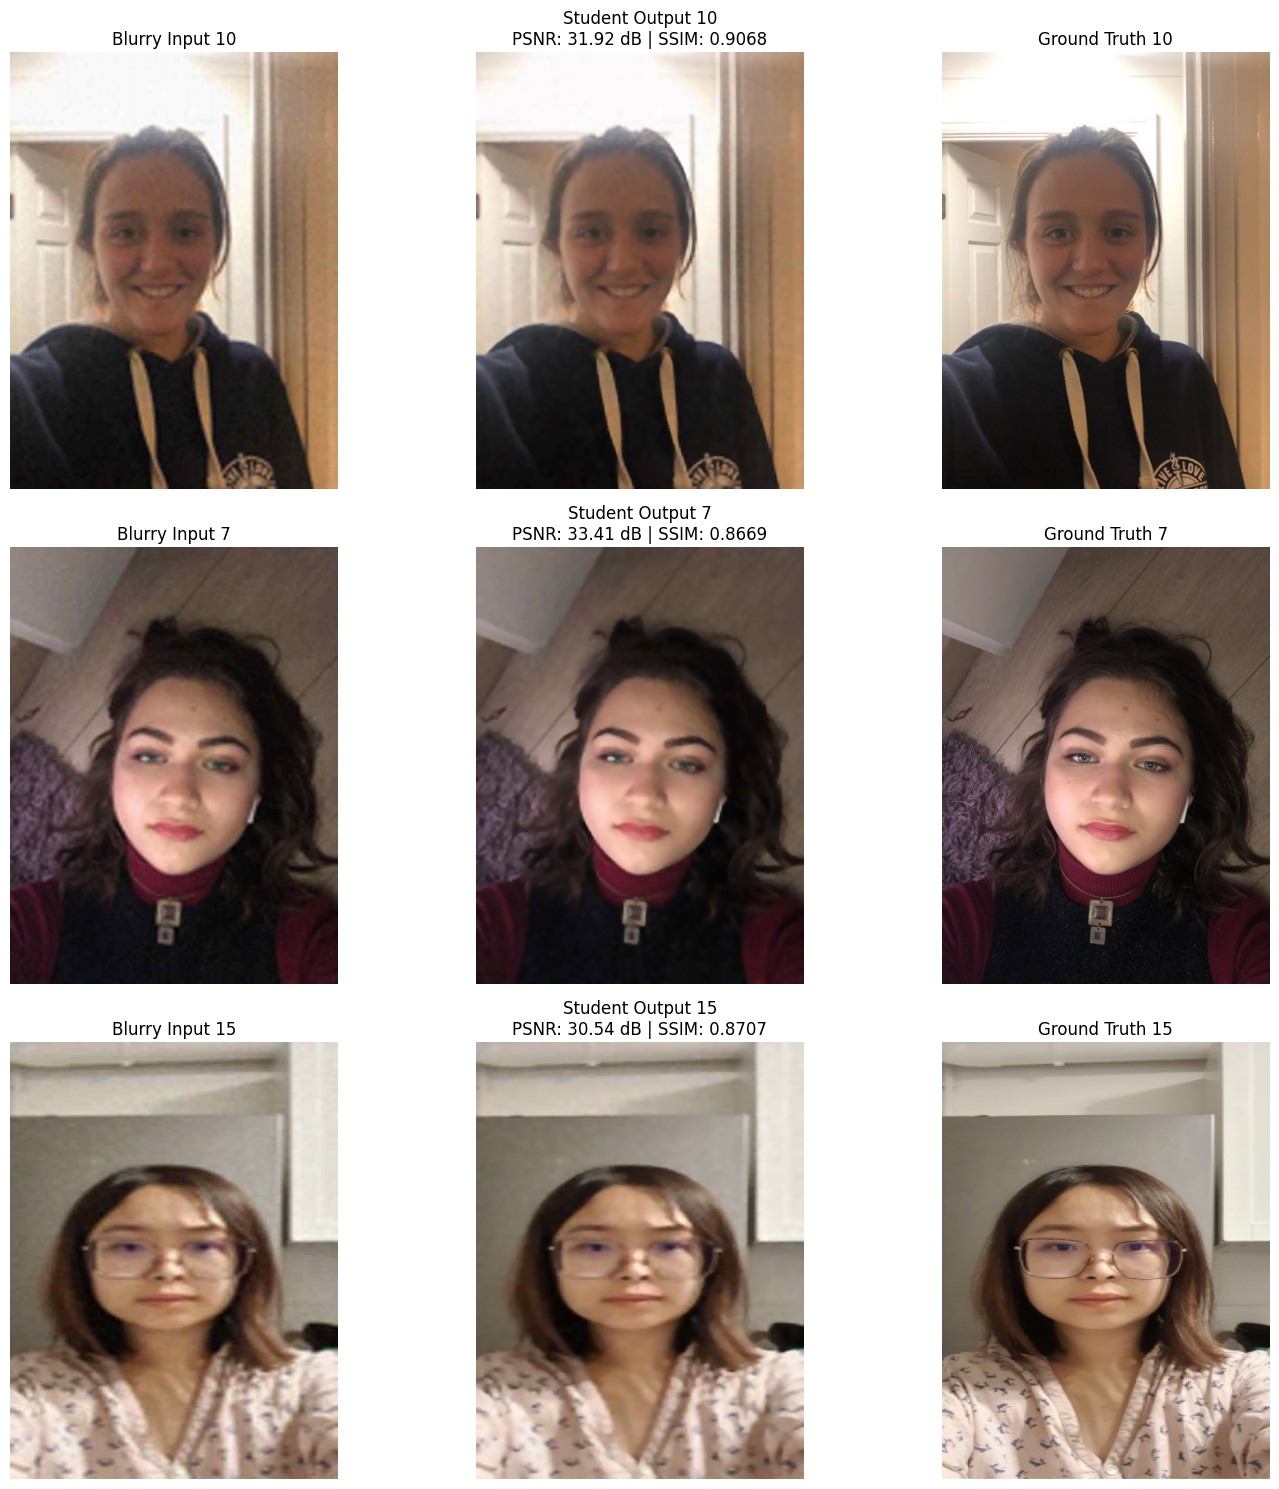


--- End of Script ---


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress TensorFlow INFO/WARNING messages

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ReLU, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import glob # For finding image files
import random
import math # For progbar fix if target is 0

# --- Configuration ---
BASE_DATA_FOLDER = "final_dataset"
TRAIN_BLURRY_DIR = os.path.join(BASE_DATA_FOLDER, "train", "blurry_input")
TRAIN_GT_DIR = os.path.join(BASE_DATA_FOLDER, "train", "ground_truth")
VAL_BLURRY_DIR = os.path.join(BASE_DATA_FOLDER, "val", "blurry_input")
VAL_GT_DIR = os.path.join(BASE_DATA_FOLDER, "val", "ground_truth")
TEST_BLURRY_DIR = os.path.join(BASE_DATA_FOLDER, "test", "blurry_input")
TEST_GT_DIR = os.path.join(BASE_DATA_FOLDER, "test", "ground_truth")

IMG_HEIGHT = 640
IMG_WIDTH = None # Will be determined automatically from data
IMG_CHANNELS = 3
PATCH_SIZE_TRAIN = 128

EPOCHS_TEACHER_INITIAL_TRAINING = 15
EPOCHS_STUDENT = 15
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
ALPHA_DISTILLATION = 0.5

TEACHER_MODEL_WEIGHTS_PATH = "teacher_model_real_data_v2.weights.h5"
SOFT_TARGETS_PATH = "teacher_soft_targets_real_data_train_v2.npy"
STUDENT_MODEL_WEIGHTS_PATH = "student_model_real_data_v2.weights.h5"

# --- Data Loading and Preprocessing ---
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None: return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return img

def create_patches_from_single_image(image_blurry, image_gt, patch_size, stride):
    blurry_patches = []
    gt_patches = []
    h, w = image_blurry.shape[:2]
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            blurry_patches.append(image_blurry[i:i+patch_size, j:j+patch_size])
            gt_patches.append(image_gt[i:i+patch_size, j:j+patch_size])
    if blurry_patches:
        return np.array(blurry_patches), np.array(gt_patches)
    return None, None

def data_patch_generator(blurry_dir, gt_dir, patch_size, stride, target_img_width, shuffle=True):
    blurry_image_paths = sorted(glob.glob(os.path.join(blurry_dir, "*.jpg")))
    gt_image_paths = sorted(glob.glob(os.path.join(gt_dir, "*.jpg")))

    if not blurry_image_paths or not gt_image_paths:
        print(f"Warning: No images found in {blurry_dir} or {gt_dir}")
        return

    path_pairs = list(zip(blurry_image_paths, gt_image_paths))
    if shuffle:
        random.shuffle(path_pairs)

    for blurry_path, gt_path in path_pairs:
        if os.path.basename(blurry_path) != os.path.basename(gt_path):
            print(f"Warning: Mismatched filenames, skipping: {blurry_path}, {gt_path}")
            continue

        blurry_img_orig = load_image(blurry_path)
        gt_img_orig = load_image(gt_path)

        if blurry_img_orig is None or gt_img_orig is None:
            continue

        blurry_img_resized = cv2.resize(blurry_img_orig, (target_img_width, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
        gt_img_resized = cv2.resize(gt_img_orig, (target_img_width, IMG_HEIGHT), interpolation=cv2.INTER_AREA)

        b_patches_img, g_patches_img = create_patches_from_single_image(
            blurry_img_resized, gt_img_resized, patch_size, stride
        )

        if b_patches_img is not None:
            indices = np.arange(len(b_patches_img))
            if shuffle:
                np.random.shuffle(indices)
                b_patches_img = b_patches_img[indices]
                g_patches_img = g_patches_img[indices]

            for bp, gp in zip(b_patches_img, g_patches_img):
                yield bp, gp

def get_target_img_width(sample_dir):
    sample_image_paths = sorted(glob.glob(os.path.join(sample_dir, "*.jpg")))
    if not sample_image_paths:
        raise ValueError(f"No images found in {sample_dir} to determine target width.")
    temp_img = load_image(sample_image_paths[0])
    if temp_img is None:
        raise ValueError(f"Could not load sample image {sample_image_paths[0]} to determine width.")
    return temp_img.shape[1]

def count_total_patches(blurry_dir, gt_dir, patch_size, stride, target_img_width):
    count = 0
    blurry_image_paths = sorted(glob.glob(os.path.join(blurry_dir, "*.jpg")))
    gt_image_paths = sorted(glob.glob(os.path.join(gt_dir, "*.jpg")))

    if not blurry_image_paths:
        print(f"Warning: No blurry images found in {blurry_dir} for counting patches.")
        return 0

    path_pairs = list(zip(blurry_image_paths, gt_image_paths))
    for blurry_path, gt_path in path_pairs:
        if os.path.basename(blurry_path) != os.path.basename(gt_path):
            continue

        blurry_img_orig = load_image(blurry_path)
        gt_img_orig = load_image(gt_path)

        if blurry_img_orig is None or gt_img_orig is None:
            continue

        blurry_img_resized = cv2.resize(blurry_img_orig, (target_img_width, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
        h, w = blurry_img_resized.shape[:2]
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                count += 1
    return count

def create_tf_dataset_for_patches(blurry_dir, gt_dir, patch_size, stride, target_img_width, batch_size, shuffle=True, repeat_dataset=False):
    output_signature = (
        tf.TensorSpec(shape=(patch_size, patch_size, IMG_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(patch_size, patch_size, IMG_CHANNELS), dtype=tf.float32)
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: data_patch_generator(blurry_dir, gt_dir, patch_size, stride, target_img_width, shuffle=shuffle),
        output_signature=output_signature
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=max(1000, batch_size * 50))

    if repeat_dataset:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def load_full_images_for_test(blurry_dir, gt_dir, target_height, target_width, max_images=None):
    blurry_image_paths = sorted(glob.glob(os.path.join(blurry_dir, "*.jpg")))
    gt_image_paths = sorted(glob.glob(os.path.join(gt_dir, "*.jpg")))

    if max_images:
        blurry_image_paths = blurry_image_paths[:max_images]
        gt_image_paths = gt_image_paths[:max_images]

    X_test_full = []
    Y_test_full = []

    if target_width is None:
        print("Error: target_width for testing is None. Cannot load test images.")
        return np.array([]), np.array([])

    print(f"Loading full images for testing from {blurry_dir} and {gt_dir} (Target size: {target_height}x{target_width})...")
    for blurry_path, gt_path in tqdm(zip(blurry_image_paths, gt_image_paths), total=len(blurry_image_paths)):
        blurry_img = load_image(blurry_path)
        gt_img = load_image(gt_path)

        if blurry_img is not None and gt_img is not None:
            blurry_img_resized = cv2.resize(blurry_img, (target_width, target_height), interpolation=cv2.INTER_AREA)
            gt_img_resized = cv2.resize(gt_img, (target_width, target_height), interpolation=cv2.INTER_AREA)
            X_test_full.append(blurry_img_resized)
            Y_test_full.append(gt_img_resized)
    return np.array(X_test_full), np.array(Y_test_full)


# --- Model Architectures ---
def build_teacher_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same')(inputs); x = ReLU()(x)
    x = Conv2D(64, (3, 3), padding='same')(x); x = ReLU()(x)
    x = Conv2D(128, (3, 3), padding='same')(x); x = ReLU()(x)
    x = Conv2D(128, (3, 3), padding='same')(x); x = ReLU()(x)
    x = Conv2D(64, (3, 3), padding='same')(x); x = ReLU()(x)
    outputs = Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)
    return Model(inputs, outputs, name="teacher_model")

def build_student_model_residual(input_shape):
    inputs = Input(shape=input_shape)
    s = Conv2D(24, (3, 3), activation='relu', padding='same')(inputs)
    s = Conv2D(24, (3, 3), activation='relu', padding='same')(s)
    residual = Conv2D(input_shape[-1], (3, 3), activation='linear', padding='same')(s)
    outputs_sum = Add()([inputs, residual])
    outputs = ReLU(max_value=1.0)(outputs_sum)
    return Model(inputs, outputs, name="student_model_residual")

# --- Main Script ---
if __name__ == "__main__":
    # This block is critical. It determines the image width from your training data.
    # If this fails, the final evaluation cannot run.
    try:
        IMG_WIDTH = get_target_img_width(TRAIN_BLURRY_DIR)
        print(f"Using target IMG_WIDTH: {IMG_WIDTH} for all image resizing.")
    except ValueError as e:
        print(f"CRITICAL ERROR: Could not determine image width. {e}")
        print("Please ensure your training data exists at the specified path and is not empty.")
        exit()

    patch_input_shape = (PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN, IMG_CHANNELS)

    print("Calculating total number of training patches for teacher...")
    num_train_patches_teacher = count_total_patches(TRAIN_BLURRY_DIR, TRAIN_GT_DIR, PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN // 2, IMG_WIDTH)
    print("Calculating total number of validation patches for teacher...")
    num_val_patches_teacher = count_total_patches(VAL_BLURRY_DIR, VAL_GT_DIR, PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN // 2, IMG_WIDTH)

    if num_train_patches_teacher == 0:
        print("CRITICAL ERROR: No training patches would be generated for the teacher model.")
        exit()

    steps_per_epoch_teacher = num_train_patches_teacher // BATCH_SIZE
    if num_train_patches_teacher % BATCH_SIZE != 0:
        steps_per_epoch_teacher += 1

    validation_steps_teacher = 0
    if num_val_patches_teacher > 0:
        validation_steps_teacher = num_val_patches_teacher // BATCH_SIZE
        if num_val_patches_teacher % BATCH_SIZE != 0:
            validation_steps_teacher += 1
    else:
        print("Warning: No validation patches for teacher. Validation will be skipped during teacher training.")

    print(f"Teacher: {num_train_patches_teacher} train patches, {steps_per_epoch_teacher} steps_per_epoch.")
    if validation_steps_teacher > 0:
        print(f"Teacher: {num_val_patches_teacher} val patches, {validation_steps_teacher} validation_steps.")

    # 1. Teacher Model
    teacher_model = build_teacher_model(patch_input_shape)
    teacher_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mae')

    if os.path.exists(TEACHER_MODEL_WEIGHTS_PATH):
        print(f"Loading pre-trained teacher model weights from {TEACHER_MODEL_WEIGHTS_PATH}")
        teacher_model.load_weights(TEACHER_MODEL_WEIGHTS_PATH)
    else:
        print("Setting up Teacher training data...")
        train_tf_dataset_teacher = create_tf_dataset_for_patches(
            TRAIN_BLURRY_DIR, TRAIN_GT_DIR, PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN // 2, IMG_WIDTH, BATCH_SIZE,
            shuffle=True, repeat_dataset=True
        )
        val_tf_dataset_teacher = None
        if validation_steps_teacher > 0:
            val_tf_dataset_teacher = create_tf_dataset_for_patches(
                VAL_BLURRY_DIR, VAL_GT_DIR, PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN // 2, IMG_WIDTH, BATCH_SIZE,
                shuffle=False, repeat_dataset=True
            )

        print("Training teacher model...")
        teacher_model.summary()
        teacher_history = teacher_model.fit(
            train_tf_dataset_teacher,
            validation_data=val_tf_dataset_teacher,
            epochs=EPOCHS_TEACHER_INITIAL_TRAINING,
            steps_per_epoch=steps_per_epoch_teacher if steps_per_epoch_teacher > 0 else 1,
            validation_steps=validation_steps_teacher if validation_steps_teacher > 0 else None,
            verbose=1
        )
        teacher_model.save_weights(TEACHER_MODEL_WEIGHTS_PATH)
        print(f"Teacher model weights saved to {TEACHER_MODEL_WEIGHTS_PATH}")

    teacher_model.trainable = False

    # 2. Soft Targets Generation
    CAN_LOAD_FULL_SOFT_TARGETS = False
    soft_targets_train_loaded_array = None

    if os.path.exists(SOFT_TARGETS_PATH) and \
       os.path.exists(TEACHER_MODEL_WEIGHTS_PATH) and \
       os.path.getmtime(SOFT_TARGETS_PATH) > os.path.getmtime(TEACHER_MODEL_WEIGHTS_PATH):
        print(f"Loading cached soft targets from {SOFT_TARGETS_PATH}")
        try:
            soft_targets_train_loaded_array = np.load(SOFT_TARGETS_PATH, mmap_mode='r' if num_train_patches_teacher * PATCH_SIZE_TRAIN*PATCH_SIZE_TRAIN*3*4 > 1e9 else None)
            CAN_LOAD_FULL_SOFT_TARGETS = True
            if soft_targets_train_loaded_array.shape[0] != num_train_patches_teacher:
                print(f"Warning: Cached soft targets ({soft_targets_train_loaded_array.shape[0]}) mismatch calculated patches ({num_train_patches_teacher}). Regenerating.")
                CAN_LOAD_FULL_SOFT_TARGETS = False
                soft_targets_train_loaded_array = None
        except (MemoryError, ValueError) as e:
            print(f"Error loading soft_targets_train.npy: {e}. Will regenerate.")
            CAN_LOAD_FULL_SOFT_TARGETS = False
    else:
        CAN_LOAD_FULL_SOFT_TARGETS = False

    if not CAN_LOAD_FULL_SOFT_TARGETS:
        print("Generating soft targets from teacher model (in batches)...")
        train_blurry_patches_tf_dataset_for_predict = create_tf_dataset_for_patches(
            TRAIN_BLURRY_DIR, TRAIN_GT_DIR, PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN // 2, IMG_WIDTH, BATCH_SIZE,
            shuffle=False, repeat_dataset=False
        ).map(lambda x, y: x)

        print("Predicting soft targets...")
        try:
            soft_targets_train_generated_array = teacher_model.predict(
                train_blurry_patches_tf_dataset_for_predict,
                verbose=1
            )
            np.save(SOFT_TARGETS_PATH, soft_targets_train_generated_array)
            print(f"Soft targets saved to {SOFT_TARGETS_PATH}")
            soft_targets_train_loaded_array = soft_targets_train_generated_array
            CAN_LOAD_FULL_SOFT_TARGETS = True
        except Exception as e:
            print(f"An error occurred during soft target generation: {e}")
            exit()


    if not CAN_LOAD_FULL_SOFT_TARGETS or soft_targets_train_loaded_array is None:
        print("Critical Error: Soft targets could not be loaded or generated. Student training cannot proceed.")
        exit()

    # 3. Student Model Training
    num_student_train_samples = soft_targets_train_loaded_array.shape[0]
    print(f"Number of training samples for student (from soft targets): {num_student_train_samples}")

    def student_distillation_data_generator(blurry_dir, gt_dir, soft_targets_arr, patch_size, stride, target_img_width):
        patch_idx = 0
        base_patch_gen = data_patch_generator(
            blurry_dir, gt_dir, patch_size, stride, target_img_width, shuffle=False
        )
        for blurry_patch, gt_patch in base_patch_gen:
            if patch_idx < len(soft_targets_arr):
                soft_target_for_patch = soft_targets_arr[patch_idx]
                yield blurry_patch, gt_patch, soft_target_for_patch
                patch_idx += 1
            else:
                break

    student_model = build_student_model_residual(patch_input_shape)
    student_model.summary()
    mae_loss_fn = tf.keras.losses.MeanAbsoluteError()
    student_optimizer = Adam(learning_rate=LEARNING_RATE)

    @tf.function
    def train_step_distill(blurry_batch, gt_sharp_batch, teacher_soft_target_batch):
        with tf.GradientTape() as tape:
            student_predictions = student_model(blurry_batch, training=True)
            hard_loss = mae_loss_fn(gt_sharp_batch, student_predictions)
            soft_loss = mae_loss_fn(teacher_soft_target_batch, student_predictions)
            total_loss = (1 - ALPHA_DISTILLATION) * hard_loss + ALPHA_DISTILLATION * soft_loss
        gradients = tape.gradient(total_loss, student_model.trainable_variables)
        student_optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))
        return total_loss, hard_loss, soft_loss

    @tf.function
    def val_step_student(blurry_batch, gt_sharp_batch):
        student_predictions = student_model(blurry_batch, training=False)
        val_loss = mae_loss_fn(gt_sharp_batch, student_predictions)
        return val_loss, student_predictions

    print("\n--- Training Student Model with Knowledge Distillation ---")
    val_tf_dataset_student = create_tf_dataset_for_patches(
        VAL_BLURRY_DIR, VAL_GT_DIR, PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN // 2, IMG_WIDTH, BATCH_SIZE,
        shuffle=False, repeat_dataset=False
    )

    output_signature_student = (
        tf.TensorSpec(shape=(PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN, IMG_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN, IMG_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN, IMG_CHANNELS), dtype=tf.float32)
    )

    train_tf_dataset_student = tf.data.Dataset.from_generator(
        lambda: student_distillation_data_generator(
            TRAIN_BLURRY_DIR, TRAIN_GT_DIR, soft_targets_train_loaded_array,
            PATCH_SIZE_TRAIN, PATCH_SIZE_TRAIN // 2, IMG_WIDTH
        ),
        output_signature=output_signature_student
    )

    if num_student_train_samples > 0:
        shuffle_buffer_size = max(1000, BATCH_SIZE * 50)
        train_tf_dataset_student = train_tf_dataset_student.shuffle(
            buffer_size=min(num_student_train_samples, shuffle_buffer_size)
        ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        train_tf_dataset_student = train_tf_dataset_student.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    epoch_total_loss_avg = tf.keras.metrics.Mean(name='train_total_loss')
    epoch_hard_loss_avg = tf.keras.metrics.Mean(name='train_hard_loss')
    epoch_soft_loss_avg = tf.keras.metrics.Mean(name='train_soft_loss')
    epoch_val_loss_avg = tf.keras.metrics.Mean(name='val_loss')
    best_val_loss = float('inf')

    if num_student_train_samples > 0 and EPOCHS_STUDENT > 0:
        for epoch in range(EPOCHS_STUDENT):
            print(f"\nStudent Epoch {epoch+1}/{EPOCHS_STUDENT}")
            epoch_total_loss_avg.reset_state(); epoch_hard_loss_avg.reset_state(); epoch_soft_loss_avg.reset_state(); epoch_val_loss_avg.reset_state()

            pbar_student_train = tqdm(train_tf_dataset_student, desc="Training Student", leave=False)
            for blurry_b, gt_b, teacher_soft_b in pbar_student_train:
                total_loss, hard_loss, soft_loss = train_step_distill(blurry_b, gt_b, teacher_soft_b)
                epoch_total_loss_avg.update_state(total_loss); epoch_hard_loss_avg.update_state(hard_loss); epoch_soft_loss_avg.update_state(soft_loss)
                pbar_student_train.set_postfix({
                    'Total Loss': f'{epoch_total_loss_avg.result():.4f}',
                    'Hard Loss': f'{epoch_hard_loss_avg.result():.4f}',
                    'Soft Loss': f'{epoch_soft_loss_avg.result():.4f}'
                })
            print(f"Student Train Loss: {epoch_total_loss_avg.result():.4f} (Hard: {epoch_hard_loss_avg.result():.4f}, Soft: {epoch_soft_loss_avg.result():.4f})")

            pbar_student_val = tqdm(val_tf_dataset_student, desc="Validating Student", leave=False)
            for blurry_b_val, gt_b_val in pbar_student_val:
                val_loss, _ = val_step_student(blurry_b_val, gt_b_val)
                epoch_val_loss_avg.update_state(val_loss)
                pbar_student_val.set_postfix({'Val MAE': f'{epoch_val_loss_avg.result():.4f}'})

            current_epoch_val_loss = epoch_val_loss_avg.result()
            print(f"Student Val Loss (MAE): {current_epoch_val_loss:.4f}")

            if current_epoch_val_loss < best_val_loss:
                print(f"Val loss improved from {best_val_loss:.4f} to {current_epoch_val_loss:.4f}. Saving student model: {STUDENT_MODEL_WEIGHTS_PATH}")
                best_val_loss = current_epoch_val_loss
                student_model.save_weights(STUDENT_MODEL_WEIGHTS_PATH)
            else:
                print(f"Val loss did not improve from {best_val_loss:.4f}.")
    else:
        print("Skipping student training loop as there are no samples or epochs.")


    # 4. Final Evaluation on Test Set
    print("\n--- Evaluating Final Student Model on Test Set ---")
    if IMG_WIDTH is None:
        print("IMG_WIDTH not determined. Skipping final evaluation.")
    elif not os.path.exists(STUDENT_MODEL_WEIGHTS_PATH):
        print(f"Student model weights not found at {STUDENT_MODEL_WEIGHTS_PATH}. Skipping final evaluation.")
    else:
        print(f"Loading best student model weights from {STUDENT_MODEL_WEIGHTS_PATH}")
        full_image_input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
        final_student_model = build_student_model_residual(full_image_input_shape)
        final_student_model.load_weights(STUDENT_MODEL_WEIGHTS_PATH)

        X_test_full, Y_test_full = load_full_images_for_test(TEST_BLURRY_DIR, TEST_GT_DIR, IMG_HEIGHT, IMG_WIDTH, max_images=20)

        if X_test_full.size == 0:
            print("No test images loaded. Skipping final evaluation details.")
        else:
            test_psnr_scores = []
            test_ssim_scores = []
            student_test_preds = []

            print("Predicting on test images and calculating metrics...")
            for i in tqdm(range(len(X_test_full))):
                blurry_test_img = np.expand_dims(X_test_full[i], axis=0)
                sharpened_output = final_student_model.predict(blurry_test_img, verbose=0)[0]
                sharpened_output = np.clip(sharpened_output, 0.0, 1.0)
                student_test_preds.append(sharpened_output)

                gt_img_test = Y_test_full[i]

                # Calculate PSNR
                psnr_score = tf.image.psnr(gt_img_test, sharpened_output, max_val=1.0).numpy()
                test_psnr_scores.append(psnr_score)

                # Calculate SSIM
                try:
                    win_size = min(gt_img_test.shape[0], gt_img_test.shape[1], 7)
                    if win_size < 3: win_size = 3
                    if win_size % 2 == 0: win_size -=1
                    ssim_score = structural_similarity(gt_img_test, sharpened_output, channel_axis=-1, data_range=1.0, win_size=win_size)
                except Exception as e:
                    print(f"SSIM calculation error for image {i}: {e}. Skipping for this image.")
                    ssim_score = 0
                test_ssim_scores.append(ssim_score)

            if test_ssim_scores and test_psnr_scores:
                average_psnr = np.mean(test_psnr_scores)
                average_ssim = np.mean(test_ssim_scores)
                print(f"\nAverage PSNR on Test Set: {average_psnr:.2f} dB")
                print(f"Average SSIM on Test Set: {average_ssim:.4f}")

            print("\n--- FPS Test (Conceptual) ---")
            if len(X_test_full) > 0:
                sample_hd_input = np.expand_dims(X_test_full[0], axis=0)
                _ = final_student_model.predict(sample_hd_input, verbose=0)
                num_runs = 20
                start_time = time.time()
                for _ in range(num_runs):
                    _ = final_student_model.predict(sample_hd_input, verbose=0)
                end_time = time.time()
                total_time = end_time - start_time
                if num_runs > 0 and total_time > 0:
                    average_time_per_image = total_time / num_runs
                    fps = 1 / average_time_per_image
                    print(f"Conceptual FPS on a {sample_hd_input.shape[1:]} input: {fps:.2f} (Avg time: {average_time_per_image*1000:.2f} ms)")

            print("\n--- Visualizing Sample Results from Test Set ---")
            num_display = min(3, len(X_test_full))
            if num_display > 0 and len(student_test_preds) == len(X_test_full):
                random_indices = np.random.choice(len(X_test_full), num_display, replace=False)
                plt.figure(figsize=(15, num_display * 5))
                for i, r_idx in enumerate(random_indices):
                    psnr = test_psnr_scores[r_idx]
                    ssim = test_ssim_scores[r_idx]

                    plt.subplot(num_display, 3, i * 3 + 1)
                    plt.imshow(X_test_full[r_idx])
                    plt.title(f"Blurry Input {r_idx}")
                    plt.axis('off')

                    plt.subplot(num_display, 3, i * 3 + 2)
                    plt.imshow(student_test_preds[r_idx])
                    plt.title(f"Student Output {r_idx}\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}")
                    plt.axis('off')

                    plt.subplot(num_display, 3, i * 3 + 3)
                    plt.imshow(Y_test_full[r_idx])
                    plt.title(f"Ground Truth {r_idx}")
                    plt.axis('off')
                plt.tight_layout()
                plt.show()

    print("\n--- End of Script ---")

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress TensorFlow INFO/WARNING messages

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ReLU, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
import glob
from tqdm import tqdm
import random

# --- Configuration ---
BASE_DATA_FOLDER = "final_dataset"
TEST_BLURRY_DIR = os.path.join(BASE_DATA_FOLDER, "test", "blurry_input")
TEST_GT_DIR = os.path.join(BASE_DATA_FOLDER, "test", "ground_truth")

# Model to load
MODEL_WEIGHTS_PATH = "student_model_real_data_v2.weights.h5"

# --- Testing & Output Configuration ---
IMG_HEIGHT = 640
IMG_WIDTH = None # Will be determined automatically
IMG_CHANNELS = 3
OUTPUT_DIR = "test_results_final"
MAX_IMAGES_TO_TEST = 50 # Process 50 images for robust metrics
NUM_VISUALIZATIONS = 5    # But only generate 5 random visual comparisons
SAVE_FIGURE_DPI = 200
FIGSIZE_COMPARISON = (18, 6)

# --- Helper Functions ---
def load_image(image_path, target_height=None, target_width=None, normalize=True):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not load image {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if target_height is not None and target_width is not None:
        img = cv2.resize(img, (target_width, target_height), interpolation=cv2.INTER_AREA)
    if normalize:
        img = img.astype(np.float32) / 255.0
    return img

def get_target_img_width(sample_dir, default_height):
    sample_image_paths = sorted(glob.glob(os.path.join(sample_dir, "*.jpg")))
    if not sample_image_paths:
        raise ValueError(f"No images found in {sample_dir} to determine target width.")

    for path in sample_image_paths[:5]: # Try a few images
        temp_img_orig = cv2.imread(path)
        if temp_img_orig is not None:
            h_orig, w_orig = temp_img_orig.shape[:2]
            aspect_ratio = w_orig / h_orig
            return int(default_height * aspect_ratio)

    raise ValueError(f"Could not load any sample images from {sample_dir} to determine width.")

# --- Model Architectures (Must match the saved weights) ---
def build_student_model_residual(input_shape):
    inputs = Input(shape=input_shape)
    s = Conv2D(24, (3, 3), activation='relu', padding='same')(inputs)
    s = Conv2D(24, (3, 3), activation='relu', padding='same')(s)
    residual = Conv2D(input_shape[-1], (3, 3), activation='linear', padding='same')(s)
    outputs_sum = Add()([inputs, residual])
    outputs = ReLU(max_value=1.0)(outputs_sum) # Clip to [0,1]
    return Model(inputs, outputs, name="student_model_residual")

# --- Main Inference and Evaluation Script ---
if __name__ == "__main__":
    if not os.path.exists(MODEL_WEIGHTS_PATH):
        print(f"ERROR: Model weights not found at {MODEL_WEIGHTS_PATH}")
        exit()

    if not os.path.exists(TEST_BLURRY_DIR):
        print(f"ERROR: Test blurry directory not found at {TEST_BLURRY_DIR}")
        exit()

    try:
        IMG_WIDTH = get_target_img_width(TEST_BLURRY_DIR, IMG_HEIGHT)
        print(f"Using image dimensions for inference: Height={IMG_HEIGHT}, Width={IMG_WIDTH}")
    except ValueError as e:
        print(f"CRITICAL ERROR: {e}. Exiting.")
        exit()

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Build and load the model
    input_shape_full = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    inference_model = build_student_model_residual(input_shape_full)
    inference_model.load_weights(MODEL_WEIGHTS_PATH)
    print("Model loaded successfully.")

    # Get the list of test images and limit it
    blurry_image_paths = sorted(glob.glob(os.path.join(TEST_BLURRY_DIR, "*.jpg")))
    if not blurry_image_paths:
        print(f"No .jpg images found in {TEST_BLURRY_DIR}")
        exit()

    # Ensure we don't try to test more images than available
    num_to_test = min(MAX_IMAGES_TO_TEST, len(blurry_image_paths))
    blurry_image_paths = blurry_image_paths[:num_to_test]
    print(f"\nProcessing {len(blurry_image_paths)} images to calculate average metrics...")

    # --- Part 1: Process all images for metrics ---
    all_psnr_scores = []
    all_ssim_scores = []

    for blurry_path in tqdm(blurry_image_paths, desc="Calculating Metrics"):
        base_filename = os.path.basename(blurry_path)
        name_part = os.path.splitext(base_filename)[0]

        blurry_img = load_image(blurry_path, IMG_HEIGHT, IMG_WIDTH)
        if blurry_img is None: continue

        blurry_img_batch = np.expand_dims(blurry_img, axis=0)
        predicted_img = inference_model.predict(blurry_img_batch, verbose=0)[0]
        predicted_img = np.clip(predicted_img, 0.0, 1.0)

        predicted_img_to_save = (predicted_img * 255).astype(np.uint8)
        predicted_img_to_save_bgr = cv2.cvtColor(predicted_img_to_save, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(OUTPUT_DIR, f"{name_part}_predicted.png"), predicted_img_to_save_bgr)

        # Load ground truth for metric calculation
        gt_path = os.path.join(TEST_GT_DIR, base_filename)
        if os.path.exists(gt_path):
            gt_img = load_image(gt_path, IMG_HEIGHT, IMG_WIDTH)
            if gt_img is not None:
                psnr = tf.image.psnr(gt_img, predicted_img, max_val=1.0).numpy()
                all_psnr_scores.append(psnr)

                win_size = min(gt_img.shape[0], gt_img.shape[1], 7)
                if win_size % 2 == 0: win_size -=1
                ssim = structural_similarity(gt_img, predicted_img, channel_axis=-1, data_range=1.0, win_size=win_size)
                all_ssim_scores.append(ssim)

    # --- Part 2: Report the average metrics ---
    print("\n--- Overall Performance Metrics ---")
    if all_psnr_scores and all_ssim_scores:
        avg_psnr = np.mean(all_psnr_scores)
        avg_ssim = np.mean(all_ssim_scores)
        print(f"Average PSNR over {len(all_psnr_scores)} images: {avg_psnr:.2f} dB")
        print(f"Average SSIM over {len(all_ssim_scores)} images: {avg_ssim:.4f}")
    else:
        print("Metrics could not be calculated. Ensure ground truth images are available.")

    # --- Part 3: Generate a few random visual comparisons ---
    print(f"\n--- Generating {NUM_VISUALIZATIONS} Random Visual Comparisons ---")
    num_to_visualize = min(NUM_VISUALIZATIONS, len(blurry_image_paths))
    random_sample_paths = random.sample(blurry_image_paths, num_to_visualize)

    for blurry_path in tqdm(random_sample_paths, desc="Creating Visuals"):
        base_filename = os.path.basename(blurry_path)
        name_part = os.path.splitext(base_filename)[0]

        # Load the necessary images for plotting
        blurry_img = load_image(blurry_path, IMG_HEIGHT, IMG_WIDTH)
        predicted_img_path = os.path.join(OUTPUT_DIR, f"{name_part}_predicted.png")
        predicted_img = load_image(predicted_img_path, IMG_HEIGHT, IMG_WIDTH)
        gt_path = os.path.join(TEST_GT_DIR, base_filename)
        gt_img = load_image(gt_path, IMG_HEIGHT, IMG_WIDTH)

        if blurry_img is None or predicted_img is None or gt_img is None:
            continue

        # Recalculate metrics for this specific image to put in the title
        psnr_val = tf.image.psnr(gt_img, predicted_img, max_val=1.0).numpy()
        win_size = min(gt_img.shape[0], gt_img.shape[1], 7)
        if win_size % 2 == 0: win_size -= 1
        ssim_val = structural_similarity(gt_img, predicted_img, channel_axis=-1, data_range=1.0, win_size=win_size)

        # Create and save comparison plot
        fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_COMPARISON)

        axes[0].imshow(blurry_img)
        axes[0].set_title("Blurry Input")
        axes[0].axis('off')

        axes[1].imshow(predicted_img)
        axes[1].set_title(f"Model Output\nPSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f}")
        axes[1].axis('off')

        axes[2].imshow(gt_img)
        axes[2].set_title("Ground Truth")
        axes[2].axis('off')

        plt.suptitle(f"Comparison for: {base_filename}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        comparison_filename = os.path.join(OUTPUT_DIR, f"{name_part}_comparison.jpg")
        plt.savefig(comparison_filename, dpi=SAVE_FIGURE_DPI, bbox_inches='tight')
        plt.close(fig)

    print(f"\nProcessing complete. Results saved in: {OUTPUT_DIR}")

Using image dimensions for inference: Height=640, Width=480
Model loaded successfully.

Processing 50 images to calculate average metrics...


Calculating Metrics: 100%|██████████| 50/50 [00:09<00:00,  5.14it/s]



--- Overall Performance Metrics ---
Average PSNR over 50 images: 31.40 dB
Average SSIM over 50 images: 0.8671

--- Generating 5 Random Visual Comparisons ---


Creating Visuals: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Processing complete. Results saved in: test_results_final


In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
!ls